# Interpolation is not Projection

In this notebook we illustatre the difference between interpolating and projecting in FEniCS

In [39]:
%matplotlib inline
import dolfin as df
import numpy as np
import matplotlib.pyplot as plt

## Mesh

Let us a create a 1d mesh, of length 1, with uniform element size

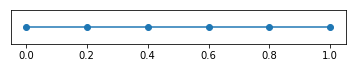

In [40]:
mesh = df.UnitIntervalMesh(5)
df.plot(mesh)

# Finite Element Discrete Function Space

Suppose that we have a continous function 
$$f: x\in \Omega\to f(x)\in \mathbb{R}$$
and we want to approximate it in the finite element space $$\mathcal{V}_n=\mathrm{span}\{\varphi_1,\ldots,\varphi_n\}$$
where the
$\varphi_i$'s are the finite element basis function. We denote the finite element approximation of $f$ by 
$$
f_n(x):=\sum_{i=1}^n F_i\varphi_i(x)
$$
where $F_i$'s are the finite element coefficients.

We discuss two methods to determine the $F_i$'s and hence $f_n$ given the function $f$ and the finite element space $\mathcal{V}_n$:
1. **Interpolation**
2. **Projection**

To make explicit example with FEniCS, let us define a mesh,  a finite element space on this mesh, and an analytical expression for a function $f$.

In [3]:
V = df.FunctionSpace(mesh,"P",1)

In [42]:
f = df.Expression('sin(5*pow(x[0],2))', degree = 4)

## Interpolation

We consider the case of Lagrange finite elements, where the degrees of freedom are the pointwise evaluation of functions in a set points, the *nodes*. Note that in linear elements the nodes concide with the vertices of the mesh, but in quadratic elements there are additional nodes. 

The interpolation imposes that for each *node* $j$ the pointwise evaluation of $f_n$ coincides with the pointwise evaluation of $f$. This give the system: 

$$
f(x_j)=f_n(x_j), \quad\forall i=1\ldots n
$$

A key property of the finite element basis function for Lagrrange elements is that $\varphi_i(x_j)=1$ if $j=i$ and $0$ if $j\neq i$. 
Hence 

$$
f_n(x_j) :=\sum_{i=1}^n F_i\varphi_i(x_j)=F_j
$$

We can conclude that the interpolation of $f$ in $V_n$ is simply obtained taking $F_i=f(x_i)$:
$$
f_n^{(\mathrm{int})}(x_j) = \sum_{i=1}^n f(x_i)\varphi_i(x_j)
$$

This is done with the command `fint_n = interpolate(f,V_n)` in FEniCS, see the example below. This is quite efficient in terms of timing.

In [44]:
f_inter = df.interpolate(f,V)

In [45]:
# components of f_inter
f_inter.vector().get_local()

array([-0.95892427, -0.05837414,  0.97384763,  0.71735609,  0.19866933,
        0.        ])

## Projection

The basic idea of the projection to obtain a finite element approximation $f_n$ of $f$ is to write the equality $f = f_n$ in weak form. We define the projection of $f$ in $\mathcal{V}_n$ as the function $f_n\in\mathcal{V}_h$ such that

$$
\int_\Omega f_n(x)\cdot \hat f(x),\mathrm{d}x
=
\int_\Omega f(x)\cdot \hat f(x),\mathrm{d}x,\quad \forall \hat f \in \mathcal{V}_n
$$

In the weak form above  $f_n$ is the unknown 'trial function', $\hat f$ is an arbritary test function in the finite element space, and $f$ is the given function to approximate. We can rewrite the equality above in the stardard form
$$
a(f_n,\hat f)=\ell(\hat f), \quad \forall \hat f \in \mathcal{V}_n
$$
where the bilinear and linear form are given by
$$
a(f_n,\hat{f})= \int_\Omega f_n(x)\cdot \hat f(x),\mathrm{d}x, 
\quad 
\ell(\hat f)=\int_\Omega f(x)\cdot \hat f(x),\mathrm{d}x,
$$
In the finite element space, writing $f_n$ and $\hat{f}$ as linear combinations of the basis functions $\varphi_i$'s, this weak fomulation gives the usual linear system
$$
\underline{\underline{A}} \,\underline{F}= \underline{b},\quad A_{ij}=a(\varphi_i,\varphi_j),\quad b_j=\ell(\varphi_j)
$$
Hence the projection of $f$ in $\mathcal{V}_n$ is given by 
$$
f_n^{\mathrm{(proj)}}(x_j) :=\sum_{i=1}^n F_i\varphi_i(x_j),
$$
where
$F_i$ is the solution to $A_{ij} F_j= b_i$.



In [49]:
f_proj = df.project(f,V)

In [47]:
# componenets of f_proj
f_proj.vector().get_local()

array([-1.25496561, -0.06308938,  1.11798238,  0.72771294,  0.16759063,
       -0.03386298])

# We now compare the two

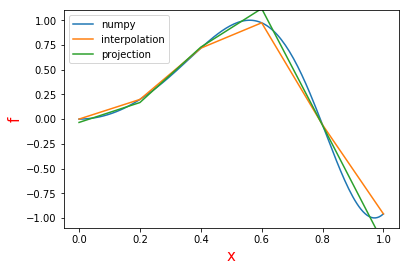

In [48]:
# we plot sin( 5 x^2 )
# and we compare to the interpolation and the projection
x = np.linspace(0, 1, 150)
y = np.sin(5*x**2)
plt.plot(x,y,label='numpy')
df.plot(f_inter,label='interpolation')
df.plot(f_proj,label='projection')
plt.xlabel('x',color='red',fontsize=15)
plt.ylabel('f',color='red',fontsize=15)
plt.legend()

In [ ]:
# EOF